# Explore change data

In [63]:
import psycopg2
from dotenv import load_dotenv
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

dotenv_path = Path().resolve().parent.parent / ".env"
load_dotenv(dotenv_path, override=True)

DB_USER = os.environ.get("DB_USER")
DB_PASS = os.environ.get("DB_PASS")
DB_NAME = os.environ.get("DB_NAME")
DB_HOST = os.environ.get("DB_HOST")
DB_PORT = os.environ.get("DB_PORT")

conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASS,
    host=DB_HOST,
    port=DB_PORT
)


In [58]:
def query_to_df(query, connection):
    with connection.cursor() as cur:
        cur.execute(query)
        # Get column names
        colnames = [desc[0] for desc in cur.description]
        # Fetch all rows
        rows = cur.fetchall()
    # Return as Pandas DataFrame
    return pd.DataFrame(rows, columns=colnames)


In [59]:
# number of processed files
df = query_to_df("""
    SELECT COUNT(DISTINCT file_path) as count_files
    FROM entity""", conn)
print('Number of processed files: ', df.loc[0,'count_files'])

# number of entities
df = query_to_df("""
    SELECT COUNT(entity_id) as count_entities
    FROM entity""", conn)
print('Number of entities: ', df.loc[0,'count_entities'])

Number of processed files:  53
Number of entities:  146868


### Number of revisions, entities over time

In [61]:
df = query_to_df("""
    SELECT revision_id, entity_id, timestamp
    FROM revision""", conn)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df["date"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()

revisions_per_period = (
    df.groupby("date")[["revision_id", "entity_id"]]
    .apply(lambda x: x.drop_duplicates().shape[0])
)

cumulative_revisions = revisions_per_period.cumsum()

entities_per_period = (
    df.groupby("date")["entity_id"].nunique()
)

entity_birth = query_to_df("""
        SELECT r.entity_id, timestamp
        FROM revision r NATURAL JOIN change
        WHERE action = 'CREATE' and target = 'ENTITY'
     """, conn) \
    .groupby("entity_id")["timestamp"].min()

entities_over_time = (
    entity_birth.value_counts()
    .sort_index()
    .cumsum()
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(cumulative_revisions.index, cumulative_revisions.values,
         label="Cumulative Revisions", marker="o", color="tab:blue")
ax1.set_title("Cumulative Revisions over time")
ax1.set_ylabel("Count")
ax1.grid(True)
ax1.legend()

ax2.plot(entities_over_time.index, entities_over_time.values,
         label="Cumulative Entities", marker="s", color="tab:orange")
ax2.set_title("Entity creation over time")
ax2.set_xlabel("Time")
ax2.set_ylabel("Count")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


OperationalError: could not receive data from server: Operation timed out


### Number of changes per entity, ordered desc

In [ ]:

df_entity_changes = query_to_df("""
    SELECT e.entity_id, e.entity_label, aux.count_changes
    FROM entity e natural join 
        (SELECT entity_id, count(revision_id) as count_changes
        FROM change
    GROUP BY entity_id) as aux
    ORDER BY aux.count_changes DESC""", conn)

print('Top 20 entities with highest number of changes')
print(df_entity_changes.head(20))

   entity_id    entity_label  count_changes
0        Q30   United States           5090
1       Q142          France           4633
2        Q41          Greece           4262
3        Q29           Spain           3980
4        Q96          Mexico           3953
5        Q31         Belgium           3654
6       Q145  United Kingdom           3567
7        Q38           Italy           3563
8        Q35         Denmark           3538
9        Q34          Sweden           3442
10       Q43          Turkey           3327
11       Q20          Norway           3260
12       Q40         Austria           3260
13       Q33         Finland           3236
14       Q17           Japan           3153
15       Q36          Poland           3113
16       Q39     Switzerland           3081
17       Q45        Portugal           2981
18       Q72          Zurich           2872
19       Q55     Netherlands           2856


### 100 most active users (high number of revisions)

In [ ]:
df_active_users = query_to_df("""
    SELECT user_id, COUNT(*) as changes
    FROM revision
    WHERE user_id IS NOT NULL and user_id != ''
    GROUP BY user_id
    ORDER BY changes DESC
    LIMIT 100
""", conn)

print(df_active_users.head(10))

   user_id  changes
0  3030127     4556
1    81600     2370
2   150965     1825
3   609373     1572
4  3012608     1511
5   130483     1436
6  4773829     1345
7  2778583     1252
8     1062     1216
9     8831     1067


### Number of changes per change type

In [44]:
df_change_types = query_to_df("""
    SELECT change_type, COUNT(*) as changes
    FROM change
    GROUP BY change_type
    ORDER BY changes DESC
""", conn)

print(df_change_types)

                         change_type  changes
0              CREATE_PROPERTY_VALUE    65106
1                    CREATE_PROPERTY    36876
2                    DELETE_PROPERTY    22775
3              UPDATE_PROPERTY_VALUE    13750
4              DELETE_PROPERTY_VALUE    12318
5  UPDATE_PROPERTY_DATATYPE_METADATA     5802
6                      CREATE_ENTITY      159


### Properties with more changes

In [45]:
df_property_changes = query_to_df("""
    SELECT property_id, COUNT(*) as changes
    FROM change
    GROUP BY property_id
    ORDER BY changes DESC
    LIMIT 100;
""", conn)

print(df_property_changes.head(20))

    property_id  changes
0         P1082    15712
1         P2131     8430
2         P2132     6267
3         P2134     6040
4         P1549     4688
5         P1279     3925
6         P2299     3536
7         P4010     3425
8   description     3188
9           P31     3144
10        label     3080
11        P2250     2705
12         P281     2423
13        P1081     2372
14         P530     2178
15         P974     2054
16        P1830     2018
17        P2936     1504
18         P463     1460
19         P443     1374


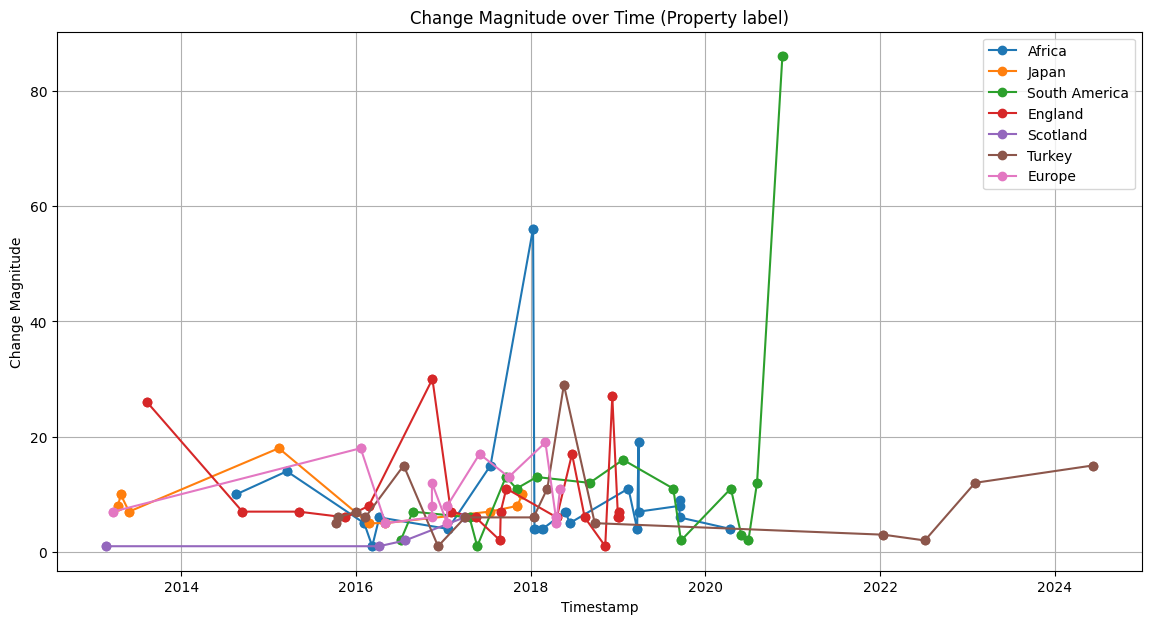

In [ ]:
# For entity X see how the magnitude of change varies over time for the label
entities = {
    "Q15": "Africa",
    "Q21": "England",
    "Q18": "South America",
    "Q17": "Japan",
    "Q22": "Scotland",
    "Q43": "Turkey",
    "Q46": "Europe"
}
property_id = "label"

# Format entity IDs for SQL IN clause
entity_ids = "', '".join(entities.keys())

df_multi_entities = query_to_df(f"""
    SELECT r.revision_id, r.timestamp, r.entity_id, aux.change_magnitude
    FROM revision r NATURAL JOIN (
        SELECT entity_id, revision_id, change_magnitude
        FROM change
        WHERE entity_id IN ('{entity_ids}') and property_id = '{property_id}' and change_magnitude IS NOT NULL
    ) AS aux
""", conn)

df_multi_entities["timestamp"] = pd.to_datetime(df_multi_entities["timestamp"])
df_multi_entities = df_multi_entities.sort_values("timestamp")

plt.figure(figsize=(14, 7))
for entity_id, group in df_multi_entities.groupby("entity_id"):
    label = entities.get(entity_id, entity_id) # entity_id if no label
    plt.plot(group["timestamp"], group["change_magnitude"],
             marker="o", linestyle="-", label=label)

plt.title(f"Change Magnitude over time (Property {property_id})")
plt.xlabel("Timestamp")
plt.ylabel("Change Magnitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
entity_id = 'Q18'
entity_label = 'South America'
property_id = 'label'

df_entity_label_changes = query_to_df(f"""
    SELECT r.revision_id, r.timestamp, r.entity_id, aux.old_value, aux.new_value, aux.change_magnitude, aux.change_type, aux.change_magnitude
    FROM revision r NATURAL JOIN (
        SELECT entity_id, revision_id, old_value, new_value, change_magnitude, change_type
        FROM change
        WHERE entity_id = '{entity_id}' and property_id = '{property_id}' and change_magnitude IS NOT NULL
    ) AS aux
--    WHERE EXTRACT(YEAR FROM r.timestamp) = 2018;
""", conn)

df_entity_label_changes

,revision_id,timestamp,entity_id,old_value,new_value,change_magnitude,change_type,change_magnitude
0,354663727,2016-07-06 02:32:01+00:00,Q18,South America,South Africa,2.0,UPDATE_PROPERTY_VALUE,2.0
1,354669527,2016-07-06 03:13:15+00:00,Q18,South Africa,South America,2.0,UPDATE_PROPERTY_VALUE,2.0
2,369565482,2016-08-26 01:34:57+00:00,Q18,South America,Chinese America,7.0,UPDATE_PROPERTY_VALUE,7.0
3,369705225,2016-08-26 07:56:57+00:00,Q18,Chinese America,South America,7.0,UPDATE_PROPERTY_VALUE,7.0
4,476676780,2017-04-20 00:20:39+00:00,Q18,South America,America,6.0,UPDATE_PROPERTY_VALUE,6.0
5,476695900,2017-04-20 02:02:13+00:00,Q18,America,South America,6.0,UPDATE_PROPERTY_VALUE,6.0
6,488148383,2017-05-22 05:26:40+00:00,Q18,South America,Southl America,1.0,UPDATE_PROPERTY_VALUE,1.0
7,488148792,2017-05-22 05:30:22+00:00,Q18,Southl America,South America,1.0,UPDATE_PROPERTY_VALUE,1.0
8,561643333,2017-09-18 22:10:15+00:00,Q18,South America,asd,13.0,UPDATE_PROPERTY_VALUE,13.0
9,561712660,2017-09-19 01:45:45+00:00,Q18,asd,South America,13.0,UPDATE_PROPERTY_VALUE,13.0


In [48]:
entity_id = 'Q15' # Africa 
entity_label = 'Africa'
property_id = 'label'

df_entity_label_changes = query_to_df(f"""
    SELECT r.revision_id, r.timestamp, r.entity_id, aux.old_value, aux.new_value, aux.change_magnitude, aux.change_type, aux.change_magnitude
    FROM revision r NATURAL JOIN (
        SELECT entity_id, revision_id, old_value, new_value, change_magnitude, change_type
        FROM change
        WHERE entity_id = '{entity_id}' and property_id = '{property_id}' and change_magnitude IS NOT NULL
    ) AS aux
--    WHERE EXTRACT(YEAR FROM r.timestamp) = 2018;
""", conn)

df_entity_label_changes

,revision_id,timestamp,entity_id,old_value,new_value,change_magnitude,change_type,change_magnitude
0,151514866,2014-08-18 19:56:14+00:00,Q15,Africa,Africa da arabia,10.0,UPDATE_PROPERTY_VALUE,10.0
1,151515462,2014-08-18 19:59:17+00:00,Q15,Africa da arabia,Africa,10.0,UPDATE_PROPERTY_VALUE,10.0
2,204743510,2015-03-18 09:55:18+00:00,Q15,Africa,en afrique du Sud,14.0,UPDATE_PROPERTY_VALUE,14.0
3,204760353,2015-03-18 13:07:29+00:00,Q15,en afrique du Sud,Africa,14.0,UPDATE_PROPERTY_VALUE,14.0
4,694560043,2018-06-12 18:21:03+00:00,Q15,Africa,Huelva,5.0,UPDATE_PROPERTY_VALUE,5.0
5,300532962,2016-02-04 15:31:24+00:00,Q15,Africa,Usa,5.0,UPDATE_PROPERTY_VALUE,5.0
6,300542117,2016-02-04 16:01:49+00:00,Q15,Usa,Africa,5.0,UPDATE_PROPERTY_VALUE,5.0
7,311345134,2016-03-09 10:05:51+00:00,Q15,Africa,frica,1.0,UPDATE_PROPERTY_VALUE,1.0
8,311354249,2016-03-09 10:23:40+00:00,Q15,frica,Africa,1.0,UPDATE_PROPERTY_VALUE,1.0
9,319830985,2016-04-08 04:00:30+00:00,Q15,Africa,Mi casa,6.0,UPDATE_PROPERTY_VALUE,6.0


In [49]:
entity_id = 'Q22' # Africa 
entity_label = 'Scotland'
property_id = 'label'

df_entity_label_changes = query_to_df(f"""
    SELECT r.revision_id, r.timestamp, r.entity_id, aux.old_value, aux.new_value, aux.change_magnitude, aux.change_type, aux.change_magnitude
    FROM revision r NATURAL JOIN (
        SELECT entity_id, revision_id, old_value, new_value, change_magnitude, change_type
        FROM change
        WHERE entity_id = '{entity_id}' and property_id = '{property_id}' and change_magnitude IS NOT NULL
    ) AS aux
--    WHERE EXTRACT(YEAR FROM r.timestamp) = 2018;
""", conn)

df_entity_label_changes

,revision_id,timestamp,entity_id,old_value,new_value,change_magnitude,change_type,change_magnitude
0,7239389,2013-02-21 09:36:03+00:00,Q22,Scotland,Scotlund,1.0,UPDATE_PROPERTY_VALUE,1.0
1,7239642,2013-02-21 09:39:49+00:00,Q22,Scotlund,Scotland,1.0,UPDATE_PROPERTY_VALUE,1.0
2,319578673,2016-04-07 11:32:11+00:00,Q22,Scotland,Scotlanda,1.0,UPDATE_PROPERTY_VALUE,1.0
3,319578999,2016-04-07 11:34:20+00:00,Q22,Scotlanda,Scotland,1.0,UPDATE_PROPERTY_VALUE,1.0
4,359385458,2016-07-24 20:41:34+00:00,Q22,Scotland,Scotland25,2.0,UPDATE_PROPERTY_VALUE,2.0
5,359409361,2016-07-25 00:23:26+00:00,Q22,Scotland25,Scotland,2.0,UPDATE_PROPERTY_VALUE,2.0
6,471166249,2017-03-29 20:26:42+00:00,Q22,Scotland,jackeline,6.0,UPDATE_PROPERTY_VALUE,6.0
7,471169846,2017-03-29 20:50:07+00:00,Q22,jackeline,Scotland,6.0,UPDATE_PROPERTY_VALUE,6.0


In [8]:
conn.close()